In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Number of days for this dataset
n_days = 365*120

In [3]:
# Generate random binary values
breakfast_gluten = np.random.randint(2, size=n_days)
morning_tea_milk = np.random.randint(2, size=n_days)
lunch_gluten = np.random.randint(2, size=n_days)
afternoon_tea_milk = np.random.randint(2, size=n_days)
dinner_gluten = np.random.randint(2, size=n_days)
toilet_diarrhea = np.random.randint(2, size=n_days)

In [4]:
# Create dataframe
df_daily = pd.DataFrame({
#     'Day': range(1, n_days + 1),
    'Breakfast': breakfast_gluten,
    'Morning_Tea': morning_tea_milk,
    'Lunch': lunch_gluten,
    'Afternoon_Tea': afternoon_tea_milk,
    'Dinner': dinner_gluten,
    'Toilet': toilet_diarrhea
})

In [5]:
df_daily = df_daily.replace({True: 1, False: 0})


In [6]:
df_daily.at[0, 'Toilet'] = 0
# Create a new column that is the sum of the other columns
df_daily['sum'] = df_daily[['Breakfast', 'Morning_Tea', 'Lunch', 'Afternoon_Tea', 'Dinner']].sum(axis=1)

# If 'sum' at row t is not 0, set 'Toilet' at row t+1 to 1
df_daily['Toilet'] = (df_daily['sum'].shift(-1) != 0).astype(int)

# Drop the 'sum' column as we don't need it anymore
df_daily.drop('sum', axis=1, inplace=True)

In [7]:
df_daily.shape

(43800, 6)

In [8]:
df_daily = df_daily.astype(int)

In [9]:
df_daily.head(10)

,Breakfast,Morning_Tea,Lunch,Afternoon_Tea,Dinner,Toilet
0,1,1,1,1,0,1
1,0,1,1,1,1,1
2,1,1,1,0,0,1
3,0,0,1,1,0,1
4,1,1,1,0,1,1
5,1,1,1,1,1,1
6,1,1,0,0,1,1
7,1,1,0,0,1,1
8,0,1,0,0,1,1
9,1,0,1,0,1,1


In [10]:
df_daily.describe()

,Breakfast,Morning_Tea,Lunch,Afternoon_Tea,Dinner,Toilet
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,0.498128,0.497626,0.496689,0.497283,0.501644,0.968447
std,0.500002,0.500000,0.499995,0.499998,0.500003,0.174807
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
df_daily['Toilet'].value_counts()

1    42418
0     1382
Name: Toilet, dtype: int64

<AxesSubplot:xlabel='Toilet', ylabel='count'>

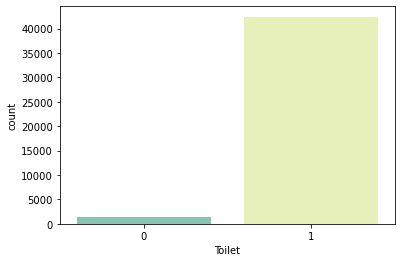

In [12]:
sns.countplot(x = df_daily['Toilet'], palette=["#7fcdbb", "#edf8b1"])

In [13]:
# # Replace 0 with 'F' and 1 with 'T'
# df_daily.replace({0: 'F', 1: 'T'}, inplace=True)

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate
from tensorflow.keras.models import Model

In [15]:
# Split dataset into train and validation
train = df_daily[:36500]
val = df_daily[36500:36500+36500]

In [16]:
# Create a time-series dataset from the dataframes, make it reusable
def timeseries_dataset(df, past, future):
    # I think shuffle should be False, correct me if I am wrong
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=np.array(df, dtype=np.float32),
        targets=None,
        sequence_length=past+future,
        sequence_stride = 1,
        shuffle = True,
        batch_size = 32,
    )

    ds = ds.map(lambda batch: (batch[:, :past, :], batch[:, past:, -1]))

    return ds

In [17]:
# Create training and validation datasets
past = 5  # previous 5 days
future = 3  # next 3 days

In [18]:
# Create a dictionary with column names as keys and empty lists as values
data = {
    'Breakfast': [],
    'Morning_Tea': [],
    'Lunch': [],
    'Afternoon_Tea': [],
    'Dinner': [],
    'Toilet': []
}

# Define the number of rows for the dataframe
num_rows = 10  # You can change this value to the desired number of rows

# Populate the dictionary with index numbers for each column
for i in range(num_rows):
    for col in data:
        data[col].append(i)

# Create the dataframe using the populated dictionary
df_temp = pd.DataFrame(data)

# Print the dataframe
print(df_temp)


   Breakfast  Morning_Tea  Lunch  Afternoon_Tea  Dinner  Toilet
0          0            0      0              0       0       0
1          1            1      1              1       1       1
2          2            2      2              2       2       2
3          3            3      3              3       3       3
4          4            4      4              4       4       4
5          5            5      5              5       5       5
6          6            6      6              6       6       6
7          7            7      7              7       7       7
8          8            8      8              8       8       8
9          9            9      9              9       9       9


In [19]:
train_temp = timeseries_dataset(df_temp, past, future)

In [20]:
def print_dataset(ds):
    for inputs, targets in ds:
        print("---Batch---")
        print("Feature:", inputs.numpy())
        print("Label:", targets.numpy())
        print("")

In [21]:
print_dataset(train_temp)

---Batch---
Feature: [[[2. 2. 2. 2. 2. 2.]
  [3. 3. 3. 3. 3. 3.]
  [4. 4. 4. 4. 4. 4.]
  [5. 5. 5. 5. 5. 5.]
  [6. 6. 6. 6. 6. 6.]]

 [[1. 1. 1. 1. 1. 1.]
  [2. 2. 2. 2. 2. 2.]
  [3. 3. 3. 3. 3. 3.]
  [4. 4. 4. 4. 4. 4.]
  [5. 5. 5. 5. 5. 5.]]

 [[0. 0. 0. 0. 0. 0.]
  [1. 1. 1. 1. 1. 1.]
  [2. 2. 2. 2. 2. 2.]
  [3. 3. 3. 3. 3. 3.]
  [4. 4. 4. 4. 4. 4.]]]
Label: [[7. 8. 9.]
 [6. 7. 8.]
 [5. 6. 7.]]



In [22]:
train_ds = timeseries_dataset(train, past, future)
val_ds = timeseries_dataset(val, past+2, future)

In [23]:
# Create subnetworks for gluten and lactose
input_layer = Input(shape=(past, df_daily.shape[-1]))




In [24]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# Assuming you have defined the 'input_layer' as mentioned
input_layer = Input(shape=(past, df_daily.shape[-1]))

# Create a dummy model with only the 'input_layer'
model222 = Model(inputs=input_layer, outputs=input_layer)

# Print the summary of the model
model222.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 6)]            0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [25]:
gluten_layer = LSTM(32)(input_layer[:, :, :3])
lactose_layer = LSTM(32)(input_layer[:, :, 3:5])

In [26]:
# Concatenate the outputs of the two subnetworks
concat_layer = Concatenate()([gluten_layer, lactose_layer])

# Dense layer for prediction
output_layer = Dense(1, activation='sigmoid')(concat_layer)

In [27]:
# Create and compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
# Train the model
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
1141/1141 [==============================] - 8s 4ms/step - loss: 0.1544 - accuracy: 0.9671 - val_loss: 0.1399 - val_accuracy: 0.9693
Epoch 2/10
1141/1141 [==============================] - 4s 4ms/step - loss: 0.1411 - accuracy: 0.9683 - val_loss: 0.1377 - val_accuracy: 0.9693
Epoch 3/10
1141/1141 [==============================] - 5s 4ms/step - loss: 0.1410 - accuracy: 0.9683 - val_loss: 0.1372 - val_accuracy: 0.9693
Epoch 4/10
1141/1141 [==============================] - 5s 4ms/step - loss: 0.1409 - accuracy: 0.9683 - val_loss: 0.1373 - val_accuracy: 0.9693
Epoch 5/10
1141/1141 [==============================] - 5s 4ms/step - loss: 0.1409 - accuracy: 0.9683 - val_loss: 0.1372 - val_accuracy: 0.9693
Epoch 6/10
1141/1141 [==============================] - 5s 4ms/step - loss: 0.1409 - accuracy: 0.9683 - val_loss: 0.1372 - val_accuracy: 0.9693
Epoch 7/10
1141/1141 [==============================] - 5s 4ms/step - loss: 0.1409 - accuracy: 0.9683 - val_loss: 0.1373 - val_accuracy:

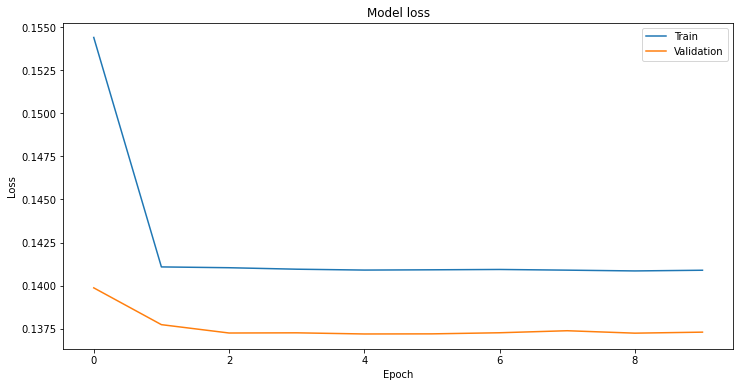

In [29]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [30]:
# Prepare the test dataset
test = df_daily[-3650:]
test_ds = timeseries_dataset(test, past, future)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

114/114 [==============================] - 0s 2ms/step - loss: 0.1447 - accuracy: 0.9671
Test Loss: 0.14470259845256805
Test Accuracy: 0.9670600295066833


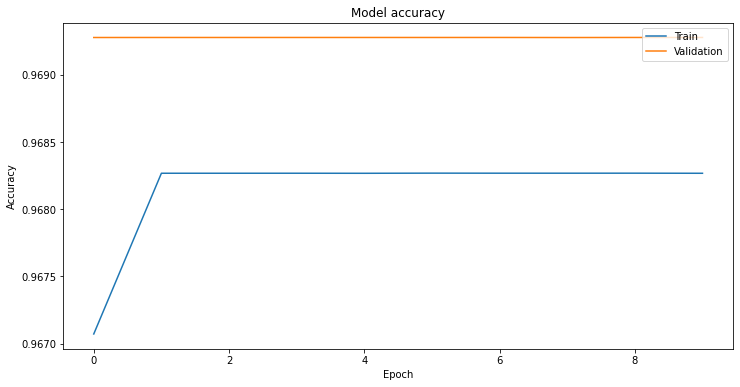

In [32]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()